# Image Classification using RBF NN

3η Υποχρεωτική Εργασία

Άννα Μαρία Βουλκοπούλου

Τμήμα Πληροφορικής

ΑΕΜ: 3945

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd

import tensorflow as tf
from tensorflow.keras import datasets
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.optimizers import Adam

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import seaborn as sn
import time
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Loading the Data

In [2]:
#Loading data in 2 sets (train, test) 
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

#Defining the 2 classes
airplane = 0
automobile = 1

#Splitting the training data
train_filter = np.where((y_train == airplane) | (y_train == automobile))[0]
X_train_filtered = X_train[train_filter]
y_train_filtered = y_train[train_filter]

#Splitting the test data
test_filter = np.where((y_test == airplane) | (y_test == automobile))[0]
X_test_filtered = X_test[test_filter]
y_test_filtered = y_test[test_filter]

#Checking the size of the datasets
print('Training data: ', X_train_filtered.shape)
print('Training classes: ', y_train_filtered.shape)
print('Test data: ', X_test_filtered.shape)
print('Test classes: ', y_test_filtered.shape)

classes =["airplane","automobile"]

Training data:  (10000, 32, 32, 3)
Training classes:  (10000, 1)
Test data:  (2000, 32, 32, 3)
Test classes:  (2000, 1)


# Normalazation of the data

In [3]:
#Flatten image to 1D vector
X_train_n = X_train_filtered.reshape(X_train_filtered.shape[0], -1)
X_test_n = X_test_filtered.reshape(X_test_filtered.shape[0], -1)

#Normalize pixel values in range of 0 and 1
X_train_n = X_train_n / 255.0
X_test_n = X_test_n  / 255.0

#Flatten labels to 1D arrays
y_train_n = y_train_filtered.ravel()
y_test_n = y_test_filtered.ravel()

#Apply PCA for dimensionality reduction
pca = PCA(n_components=0.9).fit(X_train_n)
X_train_pca = pca.transform(X_train_n)
X_test_pca = pca.transform(X_test_n)

print("We extract {} feautures from the original {}.".format(X_train_pca.shape[1],X_train_n.shape[1]))
print('Variation that can be accounted cumulatively for {} principal components: {:.2%}'.format(X_train_pca.shape[1], np.sum(pca.explained_variance_ratio_)))

We extract 95 feautures from the original 3072.
Variation that can be accounted cumulatively for 95 principal components: 90.02%


# Plotting the Dataset

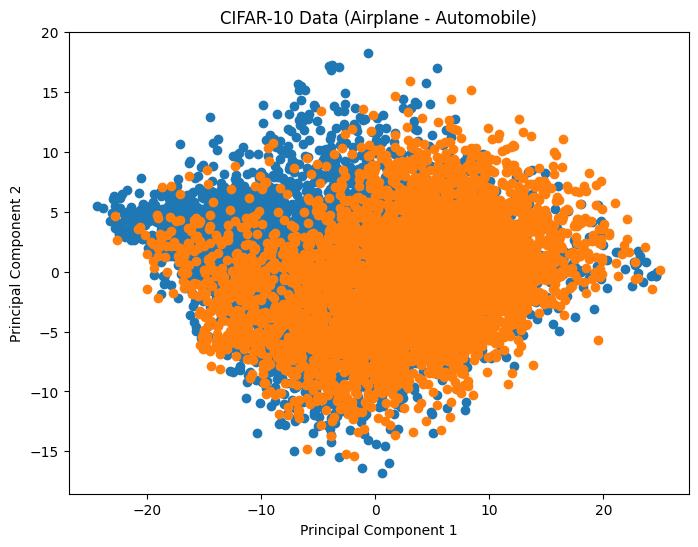

In [4]:
plt.figure(figsize=(8, 6))
#Scatter plot for the first two principal components
for i, class_name in enumerate(classes):
    class_label = [airplane, automobile][i]
    j = np.where(y_train_n == class_label)[0]
    plt.scatter(X_train_pca[j, 0], X_train_pca[j, 1], label=class_name)

plt.title('CIFAR-10 Data (Airplane - Automobile)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# KNN Classifier

In [5]:
from sklearn.neighbors import KNeighborsClassifier

# Training a k-NN classifier with k=1
knn1 = KNeighborsClassifier(1)

start = time.time()
knn1.fit(X_train_pca, y_train_n)
end = time.time()
print("Training time k=1: {:.3f}s".format(end-start))

print("Accuracy for k=1 nearest neighbors: {:.2f}%".format(knn1.score(X_test_pca,y_test_n)*100))

# Training a k-NN classifier with k=3
knn3 = KNeighborsClassifier(3)

start = time.time()
knn3.fit(X_train_pca, y_train_n)
end = time.time()
print("Training time k=3: {:.3f}s".format(end-start))

print("Accuracy for k=3 nearest neighbors: {:.2f}%".format(knn3.score(X_test_pca,y_test_n)*100))

Training time k=1: 0.002s
Accuracy for k=1 nearest neighbors: 78.20%
Training time k=3: 0.002s
Accuracy for k=3 nearest neighbors: 76.90%


# Nearest Centroid Classifier

In [6]:
from sklearn.neighbors import NearestCentroid 

# Training a NC Classifier
nc = NearestCentroid()

start = time.time()
nc.fit(X_train_pca, y_train_n)
end = time.time()
print("Training time: {:.3f}s".format(end-start))

print("Accuracy for Nearest Centroid: {:.2f}%".format(nc.score(X_test_pca,y_test_n)*100))

Training time: 0.007s
Accuracy for Nearest Centroid: 72.30%


# RBF NN

In [7]:
#Creat the RBF Kernel
def create_rbf_layer(inputs, num_cen, gamma_initializer='uniform'):
    input_dim = K.int_shape(inputs)[-1]

    #kmeans = KMeans(n_clusters=num_cen, random_state=42)
    #inputs_evaluated = kmeans.fit_transform(inputs)
    #centers = K.variable(kmeans.cluster_centers_)

    #Initialize centers randomlly(0-1)
    centers = K.variable(np.random.uniform(low=0.0, high=1.0, size=(num_cen, input_dim)))
    #Expand dimensions for broadcasting
    centers_expanded = K.expand_dims(centers, axis=0)

    #Initialize gamma randomlly(0-1)
    gamma = K.variable(np.random.uniform(low=0.0, high=1.0, size=(num_cen,)))

    #Expand dimensions for broadcasting
    inputs_expanded = K.expand_dims(inputs, axis=1)

    #Calculate distances between X and centers
    distances = K.sqrt(K.sum(K.square(inputs_expanded - centers_expanded), axis=-1))

    #Calculate RBF function(Gaussian RBF function)
    rbf = K.exp(-K.square(distances) * gamma)

    return rbf

#Build the model
def build_model(input_shape, num_centers=200):
    input_layer = layers.Input(shape=input_shape)
    
    #Hidden layer of 30 neurons
    hidden_layer = layers.Dense(50, activation='relu')(input_layer)
    
    #Passing the X to the rbf function
    rbf_output = create_rbf_layer(hidden_layer, num_centers)

    output_layer = layers.Dense(1, activation='sigmoid')(rbf_output)

    #Creating the model
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

#Splitting the data into training and valudation sets
X_train_pca, X_val_pca, y_train_n, y_val_n = train_test_split(X_train_pca, y_train_n, test_size=0.2, random_state=42)

#Compile the model
model = build_model(input_shape=(X_train_pca.shape[1],))
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Training the model
start=time.time()
history=model.fit(X_train_pca, y_train_n, epochs=10, batch_size=32, validation_data=(X_val_pca, y_val_n))
end = time.time()
print("Training time: {}s".format(end-start))

#Evaluate the accuracy of the test set
accuracy = model.evaluate(X_test_pca, y_test_n)[1]
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

#Make predictions on the test set
predictions = model.predict(X_test_pca)
predictions_binary = np.round(predictions).flatten()

Epoch 1/10
250/250 [==============================] - 1s 4ms/step - loss: 0.6200 - accuracy: 0.6148 - val_loss: 0.5333 - val_accuracy: 0.8030
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 0.4659 - accuracy: 0.8441 - val_loss: 0.4404 - val_accuracy: 0.8370
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3740 - accuracy: 0.8808 - val_loss: 0.3878 - val_accuracy: 0.8460
Epoch 4/10
250/250 [==============================] - 1s 3ms/step - loss: 0.3126 - accuracy: 0.8992 - val_loss: 0.3550 - val_accuracy: 0.8525
Epoch 5/10
250/250 [==============================] - 1s 3ms/step - loss: 0.2697 - accuracy: 0.9124 - val_loss: 0.3372 - val_accuracy: 0.8610
Epoch 6/10
250/250 [==============================] - 1s 3ms/step - loss: 0.2379 - accuracy: 0.9246 - val_loss: 0.3297 - val_accuracy: 0.8680
Epoch 7/10
250/250 [==============================] - 1s 3ms/step - loss: 0.2148 - accuracy: 0.9329 - val_loss: 0.3238 - val_accuracy: 0.8660
Epoch 

# Ploting the Loss and Accyracy Functions

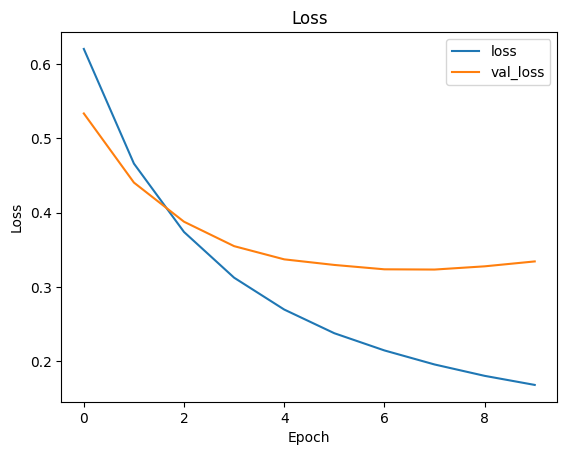

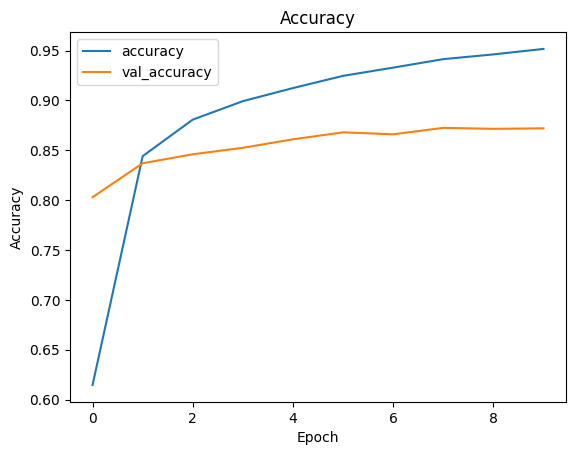

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1000
           1       0.87      0.90      0.88      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



In [8]:
#Convert history to DataFrame
history_df = pd.DataFrame(history.history)

#Plot loss
history_df[['loss', 'val_loss']].plot(title='Loss', xlabel='Epoch', ylabel='Loss')
plt.show()

#Plot accuracy
history_df[['accuracy', 'val_accuracy']].plot(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
plt.show()

#Printing a classification report for evaluation metrics
print(classification_report(y_test_n, predictions_binary))

# Confusion Matrix

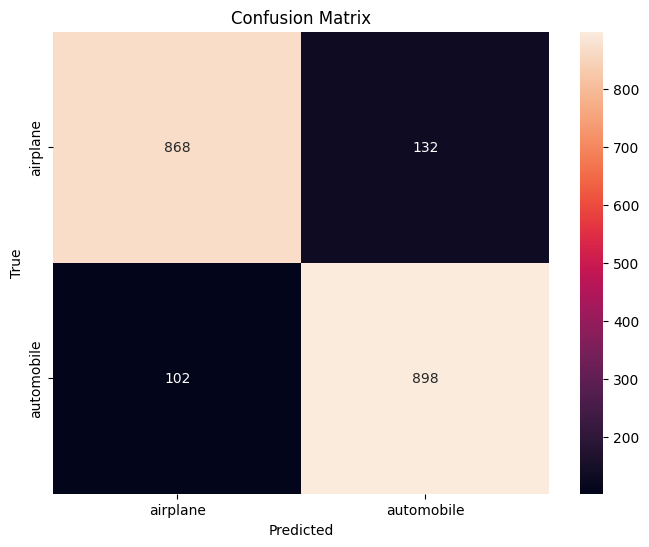

In [9]:
# Create confusion matrix
conf_mat = confusion_matrix(y_test_n, predictions_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sn.heatmap(conf_mat, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Examples of Correct and Incorect Classification

Εxamples of correct classification:


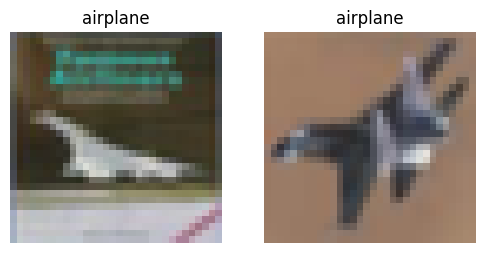

Examples of incorrect classification:


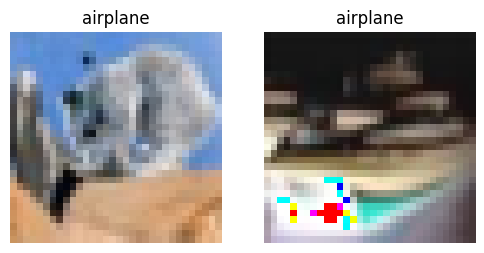

In [10]:
def print_examples(y_test, pred, X_test, labels):
    print('Εxamples of correct classification:')
    correct = 0
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    
    for i in range(y_test.shape[0]):
        # Extracting the highest probability
        pred_class = np.argmax(pred[i])
        if y_test[i] == pred_class and correct < 2:
            ax[correct].imshow((X_test[i, :] * 255).astype(int).reshape(32,32,3))
            ax[correct].set_title(labels[pred_class])
            ax[correct].axis('off')
            correct += 1
            if correct == 2:
                break
    plt.show()

    print('Examples of incorrect classification:')
    incorrect = 0
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    for i in range(y_test.shape[0]):
        pred_class = np.argmax(pred[i])
        if y_test[i] != pred_class and incorrect < 2:
            ax[incorrect].imshow((X_test[i, :] * 255).astype(int).reshape(32,32,3))
            ax[incorrect].set_title(labels[pred_class])
            ax[incorrect].axis('off')
            incorrect += 1
            if incorrect == 2:
                break
    plt.show()

print_examples(y_test, predictions_binary, X_test, classes)